<a href="https://colab.research.google.com/github/hlnynhi/PCAP/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv("https://raw.githubusercontent.com/hlnynhi/PCAP/main/Traffic-data/train.csv", index_col="_id", parse_dates=["date"])

print(df.head())
print(df.shape)


     segment_id       date  weekday  ...  lat_snode  long_enode  lat_enode
_id                                  ...                                  
0            26 2021-04-16        4  ...  10.841506  106.769254  10.842422
1            33 2020-08-02        6  ...  10.878650  106.762143  10.878808
2            33 2020-08-03        0  ...  10.878650  106.762143  10.878808
3            67 2021-03-09        1  ...  10.880817  106.768461  10.880771
4            67 2021-03-23        1  ...  10.880817  106.768461  10.880771

[5 rows x 17 columns]
(33441, 17)


In [16]:
cols = ["segment_id", "street_id", "street_name", "date", "weekday", 
        "length", "max_velocity", "street_level", "street_type", 
        "long_snode", "lat_snode", "long_enode", "lat_enode", "period", "LOS"]
df = df[cols]
df.head()

,segment_id,street_id,street_name,date,weekday,length,max_velocity,street_level,street_type,long_snode,lat_snode,long_enode,lat_enode,period,LOS
_id,,,,,,,,,,,,,,,
0,26,32575820,Nguyễn Văn Bá,2021-04-16,4,116,NaN,4,tertiary,106.768732,10.841506,106.769254,10.842422,period_0_30,A
1,33,32575862,Đường số 5,2020-08-02,6,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_23_30,C
2,33,32575862,Đường số 5,2020-08-03,0,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_0_00,D
3,67,32575862,Đường số 5,2021-03-09,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B
4,67,32575862,Đường số 5,2021-03-23,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B


In [17]:
import datetime

# 6h-8h, 16h-19h
peaks = ["period_6_00", "period_6_30", 
         "period_7_00", "period_7_30",
         "period_16_00", "period_16_30", 
         "period_17_00", "period_17_30",
         "period_18_00", "period_18_30"]

def is_special(date):
    # holidays = [(day, month)]
    holidays = [(1,1), (14,2), (8,3), (30,4), 
                (1,5), (1,6), (2,9), (20,10), 
                (20,11), (24,12), (25,12)]
    for holiday in holidays:
        if date.day == holiday[0] and\
           date.month == holiday[1]:
            return True
    return False

df["is_weekend"] = df["weekday"].apply(lambda x: int(x in [5, 6]))
df["is_peak"] = df["period"].apply(lambda p: int(p in peaks))
df["special_day"] = df["date"].apply(lambda date: int(is_special(date)))
df.head()

,segment_id,street_id,street_name,date,weekday,length,max_velocity,street_level,street_type,long_snode,lat_snode,long_enode,lat_enode,period,LOS,is_weekend,is_peak,special_day
_id,,,,,,,,,,,,,,,,,,
0,26,32575820,Nguyễn Văn Bá,2021-04-16,4,116,NaN,4,tertiary,106.768732,10.841506,106.769254,10.842422,period_0_30,A,0,0,0
1,33,32575862,Đường số 5,2020-08-02,6,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_23_30,C,1,0,0
2,33,32575862,Đường số 5,2020-08-03,0,26,NaN,3,secondary,106.761957,10.878650,106.762143,10.878808,period_0_00,D,0,0,0
3,67,32575862,Đường số 5,2021-03-09,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B,0,0,0
4,67,32575862,Đường số 5,2021-03-23,1,7,NaN,3,secondary,106.768412,10.880817,106.768461,10.880771,period_9_30,B,0,0,0


In [18]:
missing_df = pd.DataFrame((df.isna().sum() / df.shape[0]), columns=["missing_ratio"]).sort_values("missing_ratio", ascending=False)
print(missing_df)

              missing_ratio
max_velocity       0.852098
street_name        0.000030
segment_id         0.000000
lat_snode          0.000000
is_peak            0.000000
is_weekend         0.000000
LOS                0.000000
period             0.000000
lat_enode          0.000000
long_enode         0.000000
long_snode         0.000000
street_id          0.000000
street_type        0.000000
street_level       0.000000
length             0.000000
weekday            0.000000
date               0.000000
special_day        0.000000


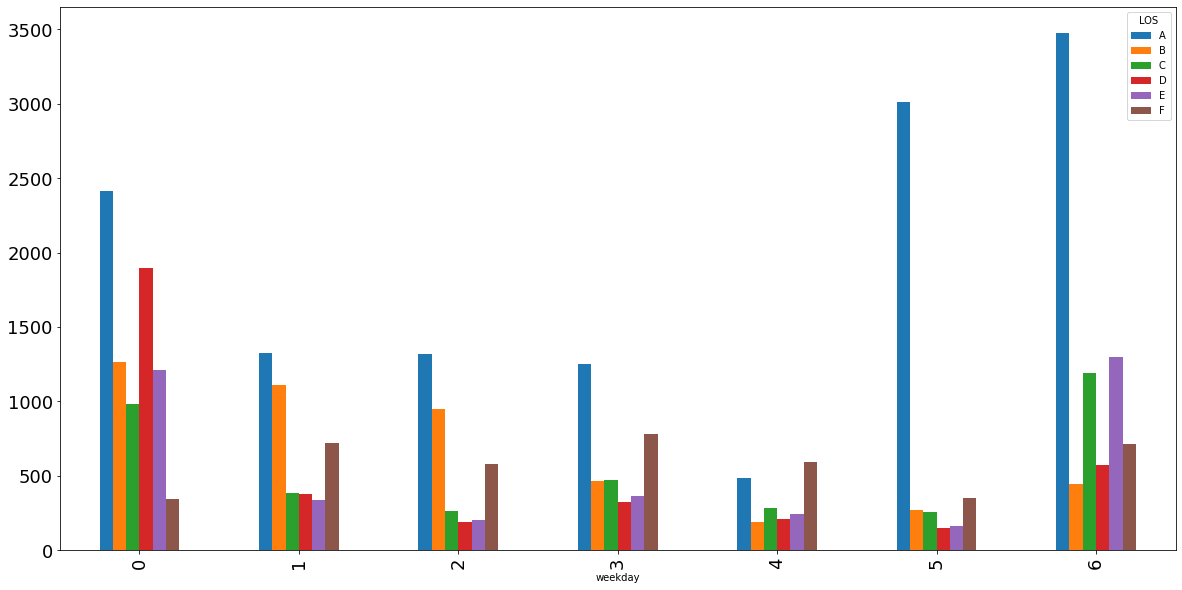

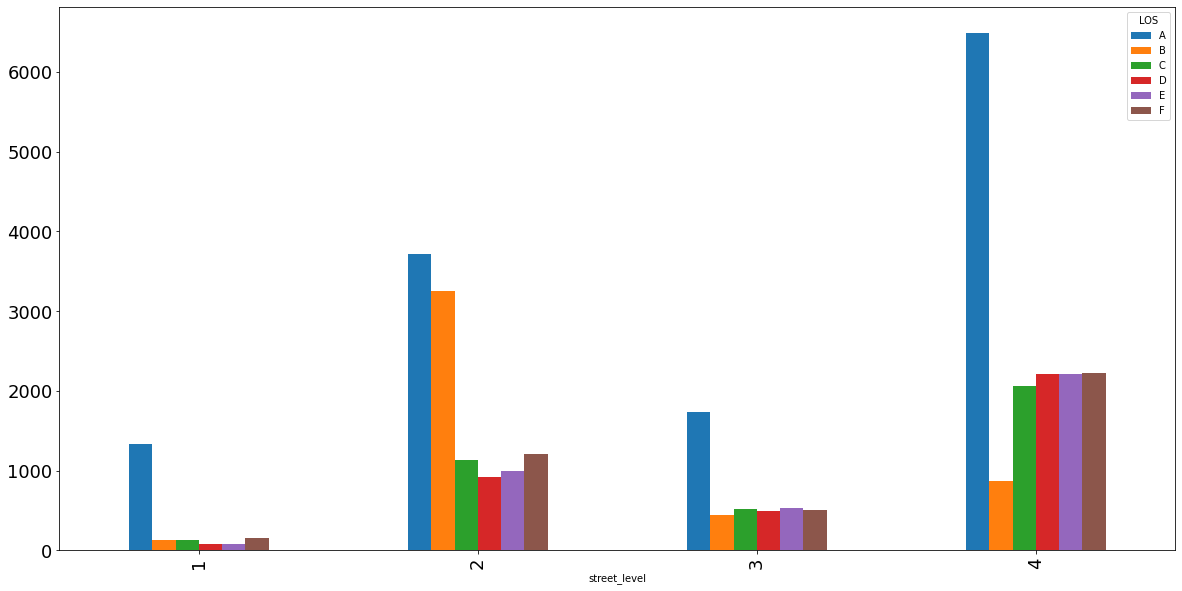

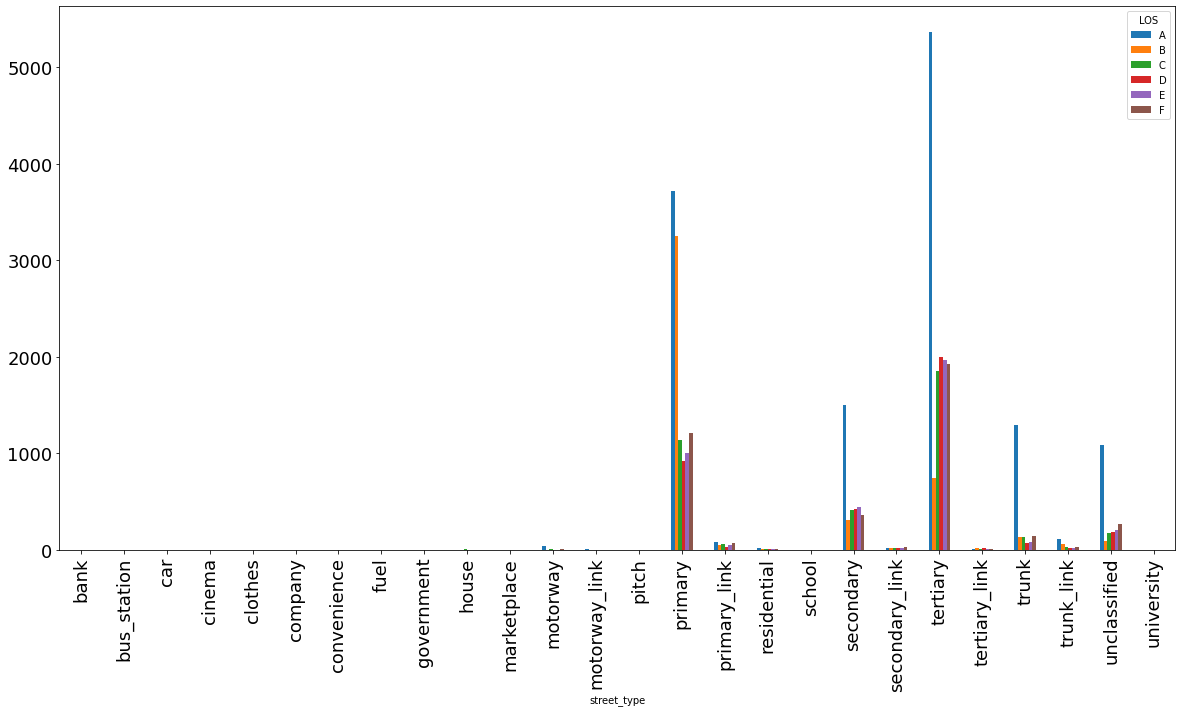

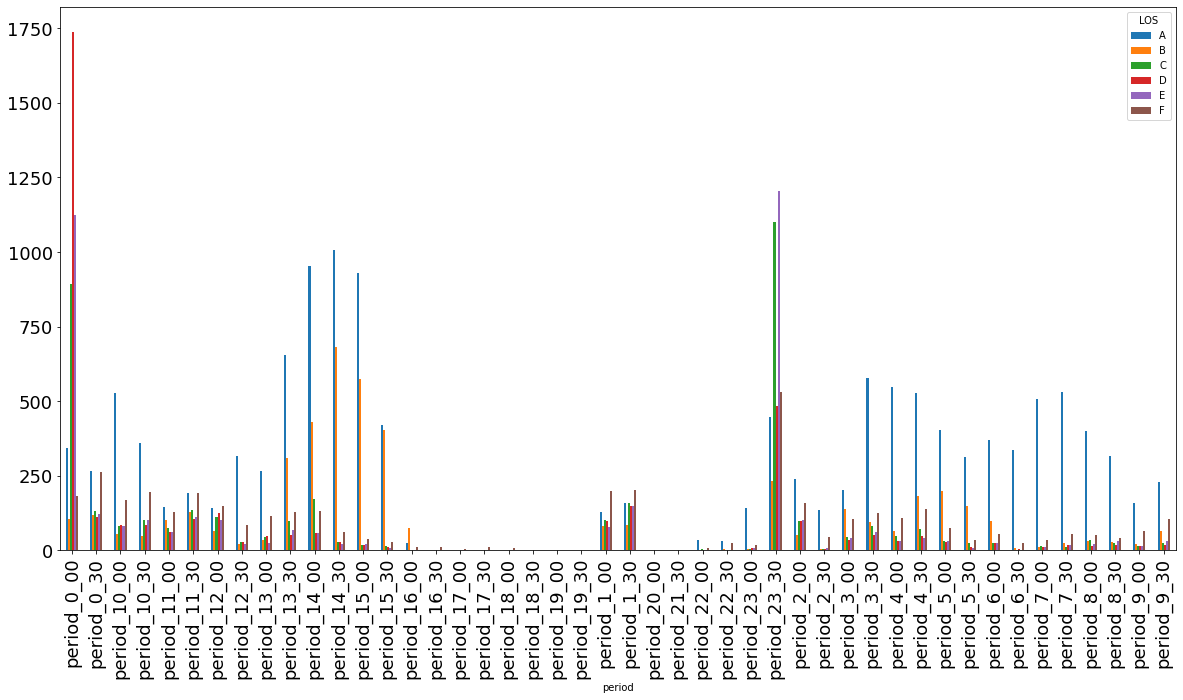

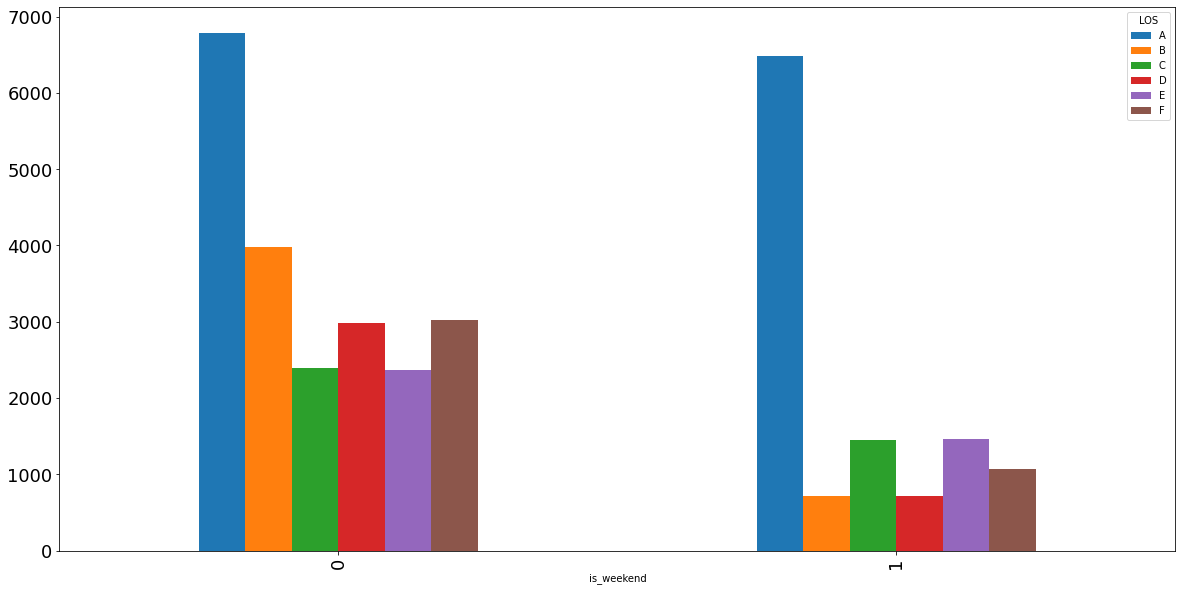

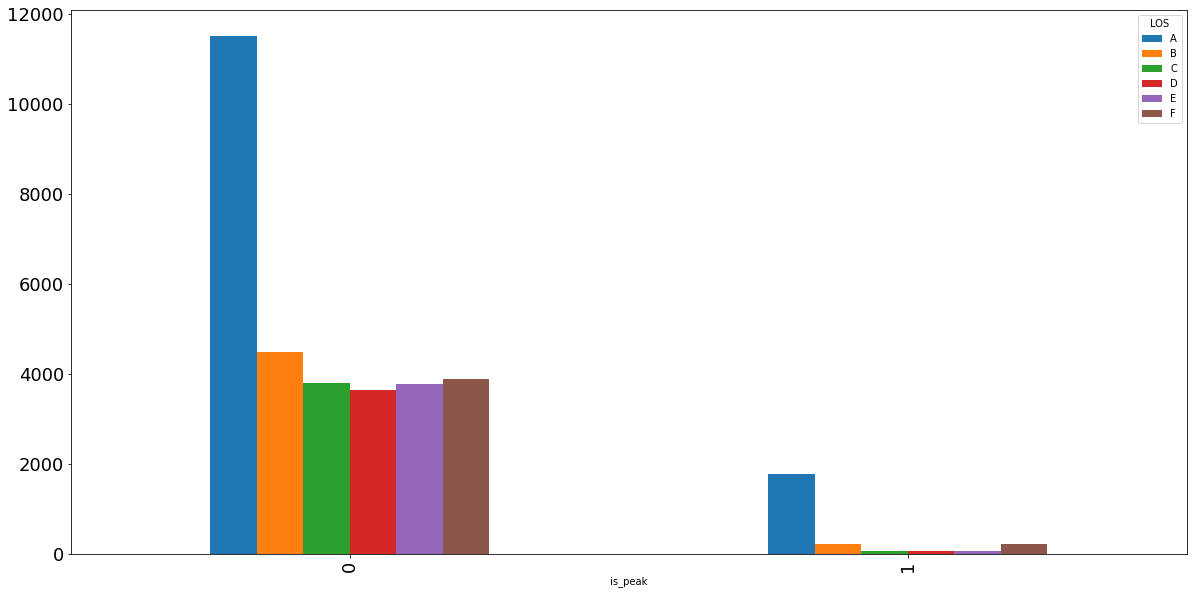

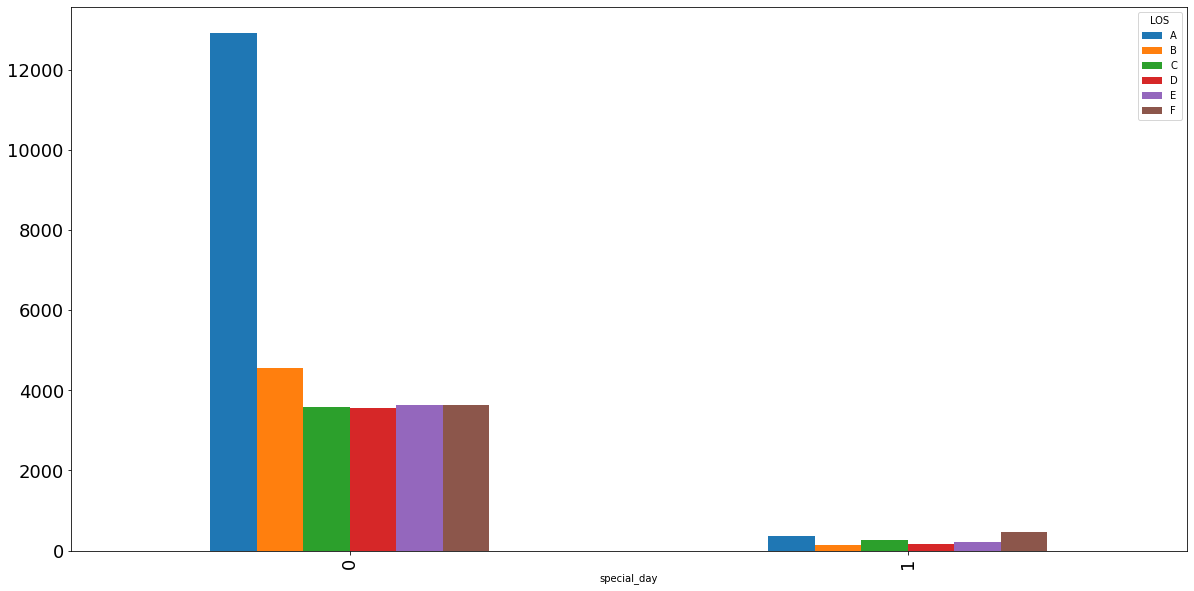

In [19]:
def plot_cat_cols_with_target(data, cols, target):
    for col in cols:
        pd.crosstab(data[col], data[target]).plot.bar(figsize=(20, 10), fontsize=18)
    plt.show()
        
cat_cols = ["weekday", "street_level", "street_type",
            "period", "is_weekend", "is_peak", "special_day"]
plot_cat_cols_with_target(df, cat_cols, "LOS")

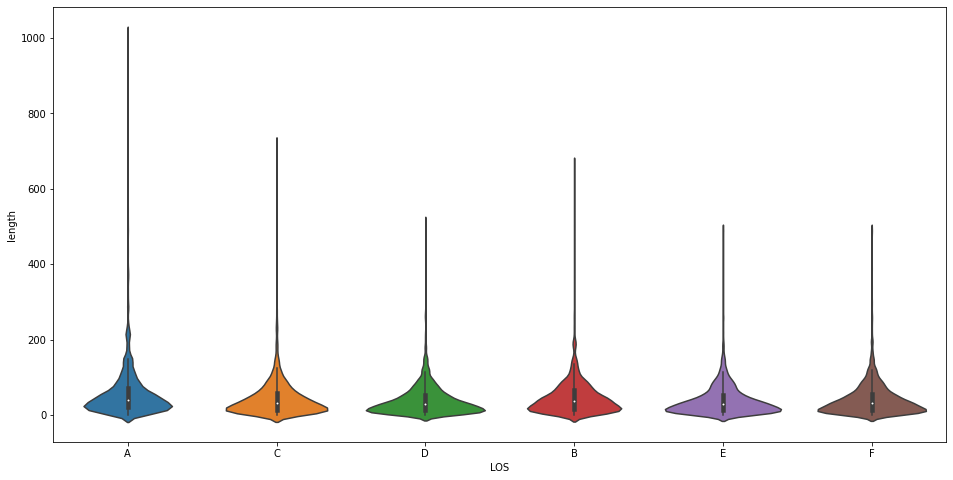

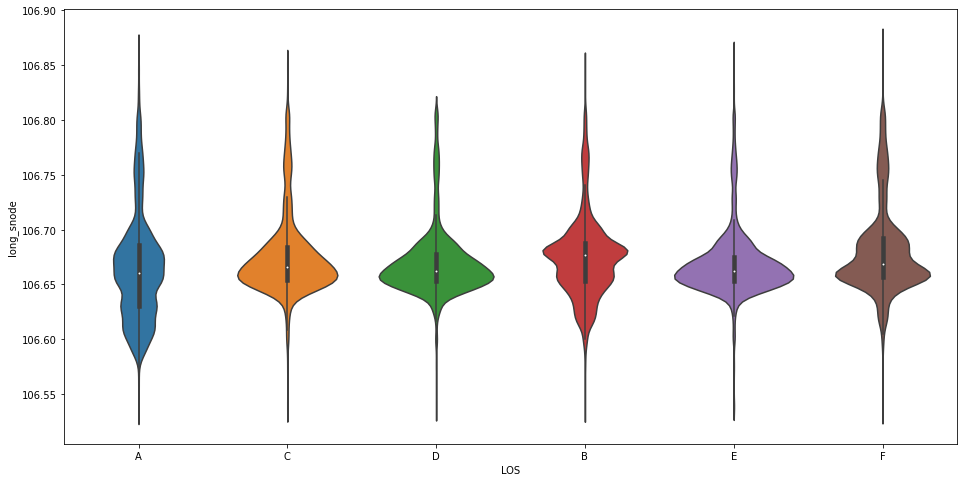

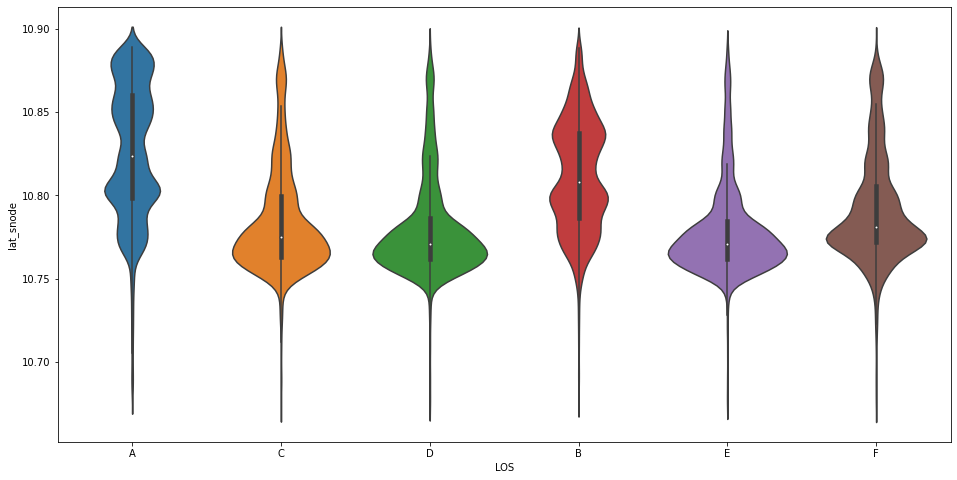

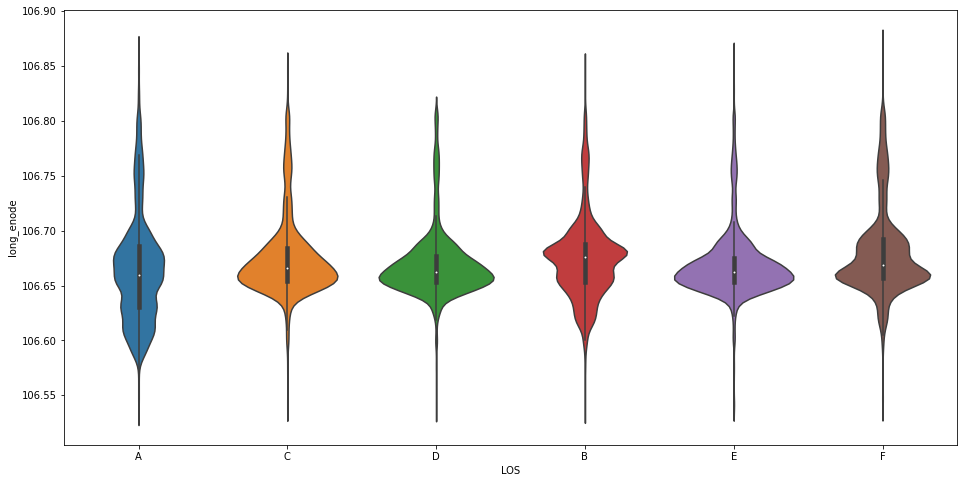

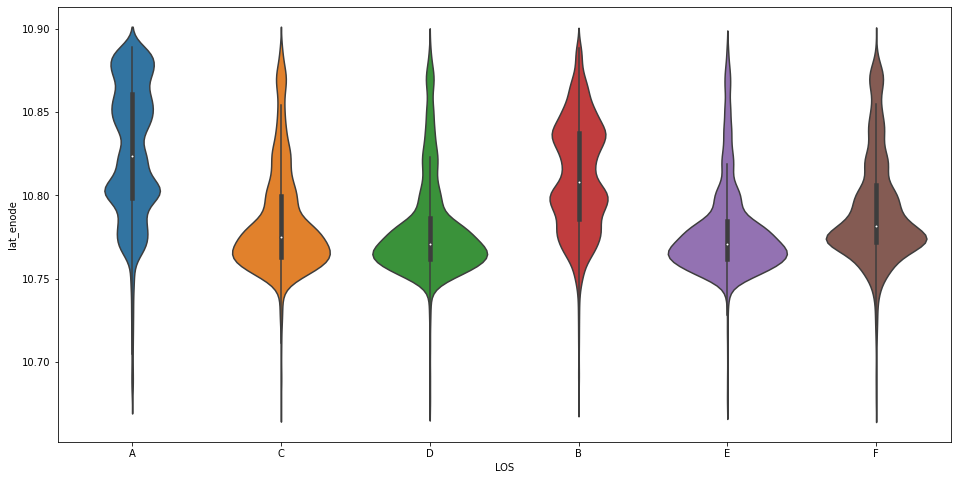

In [20]:
def plot_num_cols_with_target(data, cols, target):
    for i, col in enumerate(cols):
        plt.figure(figsize=(16, 8))
        sns.violinplot(x=target, y=col, data=data)
        plt.show()

# Ignore 'max_velocity'
num_cols = ["length", "long_snode", "lat_snode", "long_enode", "lat_enode"]
plot_num_cols_with_target(df, num_cols, "LOS")

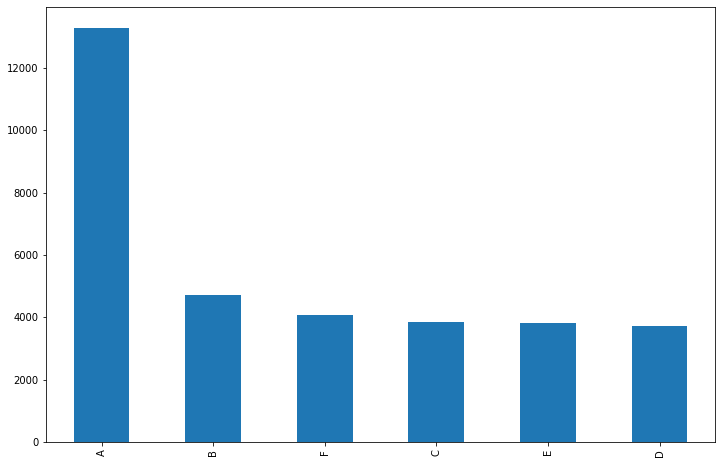

In [21]:
def check_label(target_cols):
    target_cols.value_counts().plot.bar(figsize=(12, 8))
    plt.show()
check_label(df["LOS"])

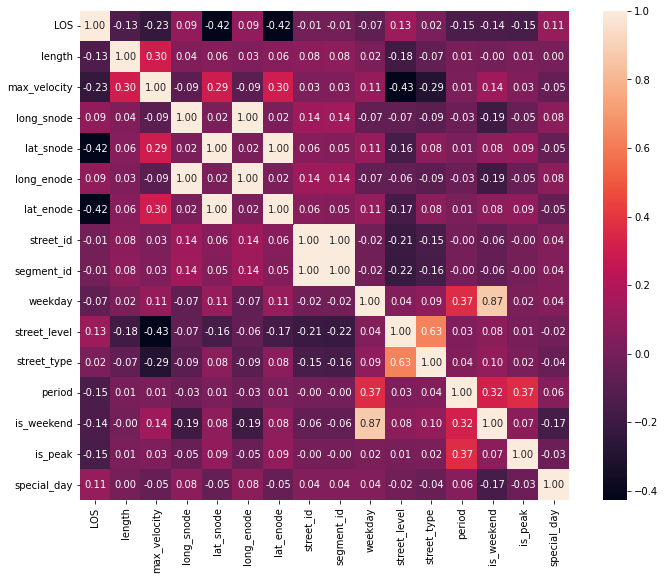

In [22]:
from sklearn.preprocessing import LabelEncoder

num_cols = ["length", "max_velocity", "long_snode", "lat_snode", "long_enode", "lat_enode"]
cat_cols = ["street_id", "segment_id", "weekday", "street_level", "street_type", "period", "is_weekend", "is_peak","special_day"]

def plot_heatmap(data):
    cols = ["LOS"] + num_cols + cat_cols
    temp_df = data[cols].copy()
    
    encoder = LabelEncoder()
    for col in cat_cols + ["LOS"]:
        temp_df[col] = encoder.fit_transform(temp_df[col])
        
    corrmat = temp_df[cols].corr()
    plt.figure(figsize=(12, 9))
    sns.heatmap(corrmat, cbar=True, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
    plt.show()

plot_heatmap(df)

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def classification_report_df(y_true, y_pred):
    classes = np.unique(y_true)
    true = label_binarize(y_true, classes=classes)
    pred = label_binarize(y_pred, classes=classes)
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i, c in enumerate(classes):
        fpr[c], tpr[c], _ = roc_curve(true[:, i], pred[:, i])
        roc_auc[c] = auc(fpr[c], tpr[c])
        
    fpr["micro"], tpr["micro"], _ = roc_curve(true.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_multiclass_roc(y_true, y_pred, title="Extension ROC to multi-class"):
    fpr, tpr, roc_auc = classification_report_df(y_true, y_pred)
    classes = fpr.keys()
    all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in classes:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= len(classes)
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    plt.figure(figsize=(12, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for c, color in zip(classes, colors):
        plt.plot(fpr[c], tpr[c], color=color, lw=lw,
                 label=f'ROC curve of class {c} (area = {roc_auc[c]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [24]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

num_features = make_column_selector(dtype_exclude=object)
cat_features = make_column_selector(dtype_include=object)

num_pipeline = Pipeline([('numerical_imputer', SimpleImputer(strategy="median")),
                         ('numerical_scaler', RobustScaler())])
cat_pipeline = Pipeline([('categorical_imputer', SimpleImputer(strategy="most_frequent")),
                         ('categorical_encoder', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = make_column_transformer((num_pipeline, num_features), (cat_pipeline, cat_features))

# Choose model
from sklearn.tree import DecisionTreeClassifier

model = Pipeline([("preprocessor", preprocessor),
                  ("classifier", DecisionTreeClassifier(random_state=0))])

In [25]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, plot_confusion_matrix

def train_and_evaluate_model(X, y, model):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    plot_confusion_matrix(model, X_val, y_val)
    print(classification_report(y_val, y_pred))
    plot_multiclass_roc(y_val, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           A       0.85      0.86      0.86      2636
           B       0.67      0.69      0.68       941
           C       0.30      0.28      0.29       803
           D       0.32      0.33      0.32       749
           E       0.26      0.26      0.26       747
           F       0.46      0.45      0.46       813

    accuracy                           0.59      6689
   macro avg       0.48      0.48      0.48      6689
weighted avg       0.59      0.59      0.59      6689



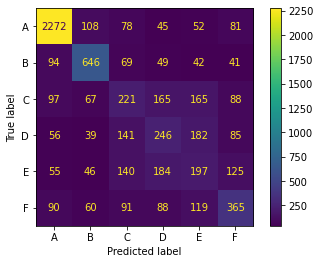

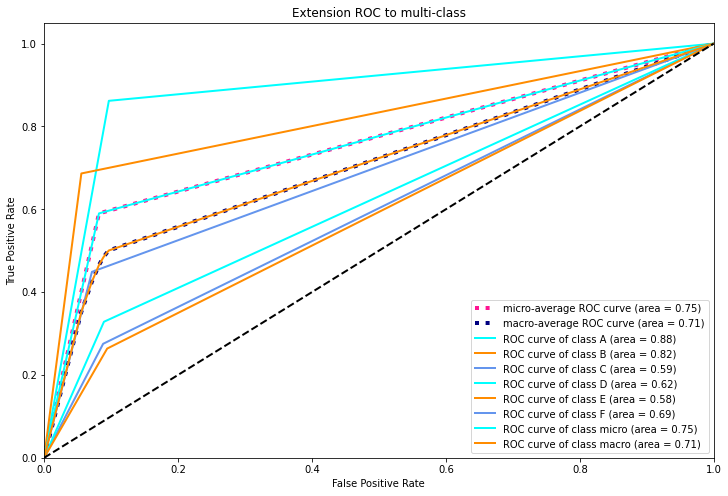

In [26]:
features = ["weekday", "length", "street_level", "street_type", "long_snode", "lat_snode", "period"]

train_and_evaluate_model(df[features], df["LOS"], model)

Before: (33441, 77) (33441,)
After: (79668, 77) (79668,)


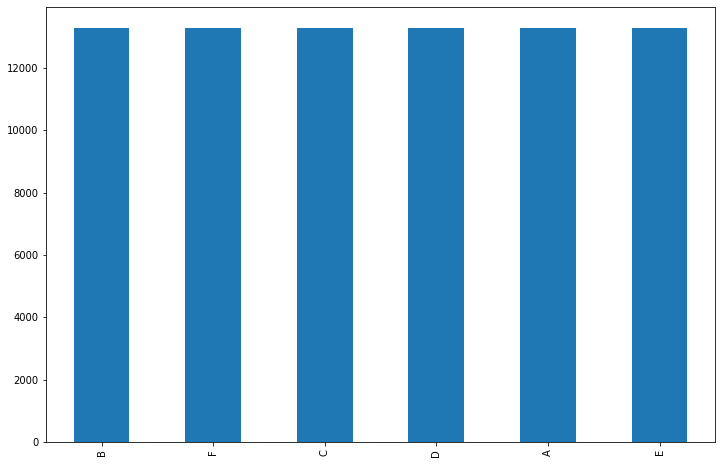

In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = preprocessor.fit_transform(df[features]), df["LOS"]
print("Before:", X.shape, y.shape)
X, y = smote.fit_resample(X, y)
print("After:", X.shape, y.shape)
y.value_counts().plot.bar(figsize=(12, 8))
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def preprocess_dataset(X, y, preprocessor, resampler, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=0)
    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_train, y_train = resampler.fit_resample(X_train, y_train)
    return X_train, X_val, y_train, y_val

def train_and_validate(X_train, X_val, y_train, y_val, model, plot_title="Extension ROC to multi-class"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(model, X_val, y_val)
    plot_multiclass_roc(y_val, y_pred, plot_title)

              precision    recall  f1-score   support

           A       0.88      0.85      0.86      2636
           B       0.66      0.70      0.68       941
           C       0.27      0.26      0.26       803
           D       0.28      0.29      0.29       749
           E       0.24      0.26      0.25       747
           F       0.43      0.42      0.42       813

    accuracy                           0.58      6689
   macro avg       0.46      0.46      0.46      6689
weighted avg       0.58      0.58      0.58      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


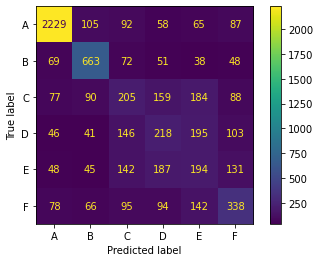

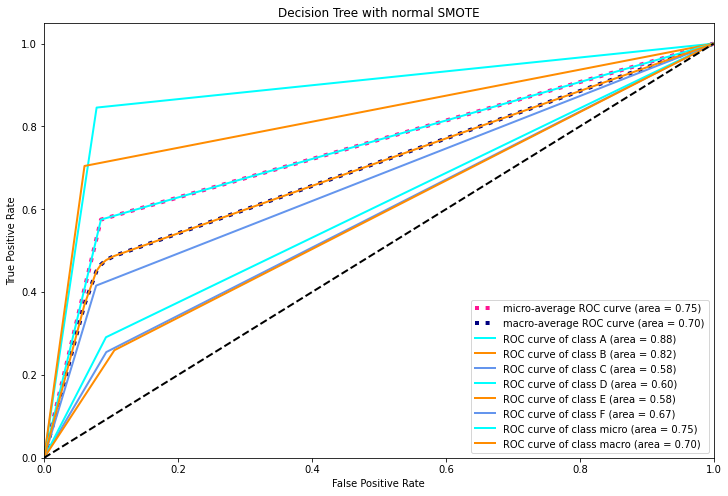

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

# Use the previous defined preprocessor
X_train, X_val, y_train, y_val = preprocess_dataset(df[features], df["LOS"], preprocessor, SMOTE())
model = DecisionTreeClassifier(random_state=0)

train_and_validate(X_train, X_val, y_train, y_val, model, "Decision Tree with normal SMOTE")

              precision    recall  f1-score   support

           A       0.87      0.83      0.85      2636
           B       0.67      0.70      0.68       941
           C       0.27      0.27      0.27       803
           D       0.30      0.33      0.32       749
           E       0.25      0.25      0.25       747
           F       0.43      0.42      0.42       813

    accuracy                           0.58      6689
   macro avg       0.46      0.47      0.47      6689
weighted avg       0.58      0.58      0.58      6689



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


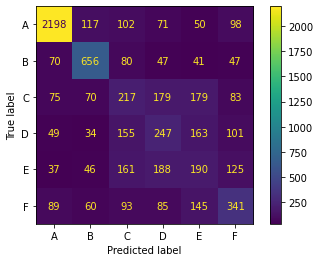

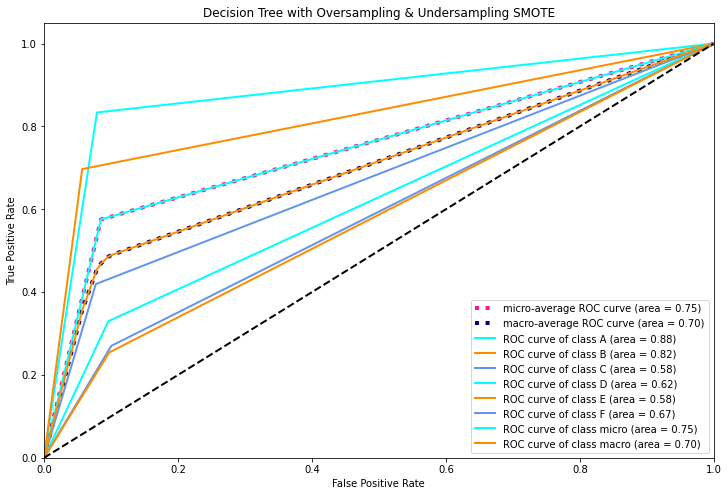

In [30]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

resampler = ImbPipeline(steps=[('o', SMOTE(sampling_strategy={"B":5000, "C":5000, "D":5000, "E":5000, "F":5000})),
                               ('u', RandomUnderSampler(sampling_strategy={"A":8000}))])
# Use the previous defined preprocessor
X_train, X_val, y_train, y_val = preprocess_dataset(df[features], df["LOS"], preprocessor, resampler)
model = DecisionTreeClassifier(random_state=0)

train_and_validate(X_train, X_val, y_train, y_val, model, "Decision Tree with Oversampling & Undersampling SMOTE")